In [1]:
from fastai.data.block import DataBlock
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

In [2]:
path = Path('/home/dant/data')

In [7]:
fns = get_image_files(path)
len(fns)

2551

In [8]:
failed = verify_images(fns)
len(failed)

1

In [9]:
failed.map(Path.unlink);


In [40]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
    # item_tfms=RandomResizedCrop(128, min_scale=0.8))


In [41]:
dls = db.dataloaders(path)

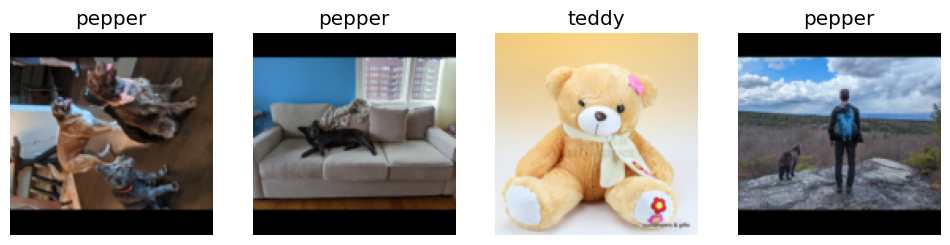

In [43]:
dls.valid.show_batch(max_n=4, nrows=1, unique=False)

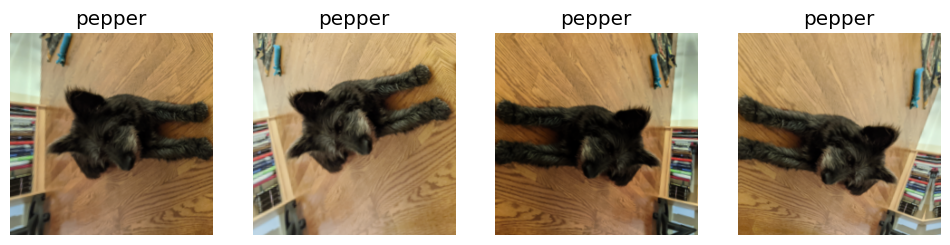

In [50]:
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.8), batch_tfms=aug_transforms())
dls = db.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


In [53]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.082372,0.152289,0.041176,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.222513,0.049546,0.013725,00:14
1,0.124212,0.040115,0.005882,00:14
2,0.073024,0.041022,0.003922,00:13
3,0.049173,0.039128,0.007843,00:14
